In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns

In [10]:
#General visualization settings
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)

In [11]:
#Path settings
root_path = Path(r"C:\Users\neurogears\OneDrive - NeuroGEARS Ltd\CricketPrelemdata\ArmBenchmarking")
session_id = "05_06_2022_16_02_29"
session_path = root_path / session_id


#### SWC-HARP and CF-HARP timing benchmarking

[0.98192024 0.98870039 0.9791398  0.97840023 0.98842001 0.97871971
 0.98880005 0.98867989 0.97863007 0.98921013 0.98883009 0.97833014
 0.97907972 0.97859001 0.97846985 0.98912001 0.97901011 0.98863983
 0.97898006 0.98863983 0.98875999 0.97874975]
Mean±std  :  983.45 [ms] ± 4.92


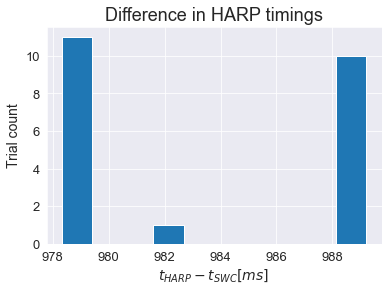

In [4]:
## Compare SWC-HARP and CF-HARP timestamping

#Load data from SWC-HARP
#Note: ARM gpio event is triggered on a falling edge
arm_falling_edge = pd.read_csv(session_path / "ArmFallingEdgeDetection.csv")
arm_falling_edge = arm_falling_edge["ToString()"].values

#Load data from CF-HARP
#Note: there is a bug wherein i am using the rising edge of a very short pulse.
#Should fix in the future!
harp_io = pd.read_csv(session_path / "BehaviorSynchPulse.csv")
harp_falling_edge = harp_io["Seconds"].values

#Calculate the timing difference
deltaTS = harp_falling_edge - arm_falling_edge

#Plot the distribution of the differences
plt.figure()
plt.hist(deltaTS*1000)
plt.xlabel("$t_{HARP} - t_{SWC} [ms]$")
plt.ylabel("Trial count")
plt.title("Difference in HARP timings")
print(deltaTS)
print("Mean±std  :  {0:.2f} [ms] ± {1:.2f}".format(np.mean(deltaTS*1000), np.std(deltaTS*1000)))

#### Benchmarking real arm movement vs SWC-HARP instruction
- Get a movement metric (trajectory or overall movie energy)
- Get the timestamp of the instruction (for now assume everything is well align which will result in a ~1second lag)
- Get the closest frames using the PWM timestamps

In [12]:
# Load movie energy data
movie_energy = pd.read_csv(session_path / "VideoEnergy.csv")["VideoEnergy"].values

# Load instructions
arm_instructions = pd.read_csv(session_path / "ArmCoords.csv")
arm_instructions.columns = ['Time', 'Magnitude', 'Angle']

# Load PWM timestamps
pwm_events = pd.read_csv(session_path / "CameraCentroid.csv")


In [13]:
#Sanity check for dropped frames
lost_frames = np.diff(pwm_events["Item2.FrameCounter"].values) - 1
print("{0} frames were lost!".format(np.sum(lost_frames)))
print(pwm_events.columns)


0 frames were lost!
Index(['Item1.CricketLed.Item1.X', 'Item1.CricketLed.Item1.Y',
       'Item1.CricketLed.Item2', 'Item1.JointLed.Item1.X',
       'Item1.JointLed.Item1.Y', 'Item1.JointLed.Item2', 'Item2.HarpTimestamp',
       'Item2.CameraClock', 'Item2.FrameCounter'],
      dtype='object')


In [7]:
arm_instructions["TrialFrame"] = ""
timeoffset = 0.97898006
for index, row in arm_instructions.iterrows():
    #find the frame right after the instruction timestamp
    instruction_timestamp = row["Time"] + timeoffset #time of the current instruction (SWC-HARP time)
    closest_frame_ts = pwm_events["Item2.HarpTimestamp"] - instruction_timestamp
    closest_frame_ts[closest_frame_ts < 0 ] = np.nan
    closest_frame_idx = (np.abs(closest_frame_ts)).argmin()
    if closest_frame_idx < 0:
        print('No data for trial ' + str(index))
        arm_instructions.loc[index, "TrialFrame"] = np.nan

    else:
        arm_instructions.loc[index, "TrialFrame"] = closest_frame_idx


# collect trial aligned data
#simplify and use fs for now...
fs = 1.0/np.mean(np.diff(pwm_events["Item2.HarpTimestamp"]))
win = (-2, 2) # seconds around instruction timestamp
win_frames = np.int32(np.array(win) * fs)
arm_instructions["TrialFrameWin_start"] = arm_instructions["TrialFrame"].values + win_frames[0]
arm_instructions["TrialFrameWin_end"] = arm_instructions["TrialFrame"].values + win_frames[1]

emptyArray = np.empty([win_frames[1] - win_frames[0],])
emptyArray[:] = np.NaN
arm_instructions["AlignedMovieEnergy"] = arm_instructions.apply(lambda x: emptyArray.copy(), axis = 1)

arm_instructions["HasData"] = False


for index, row in arm_instructions.iterrows():
    if ((row["TrialFrameWin_start"] < 0) or (row["TrialFrameWin_end"]  >  pwm_events.shape[0]) or (row["TrialFrame"] is np.nan)):
        print('Invalid data for trial ' + str(index))
    else:
        arm_instructions["HasData"] = True
        arm_instructions.loc[index,"AlignedMovieEnergy"][:] = movie_energy[row["TrialFrameWin_start"]:row["TrialFrameWin_end"]].copy()






No data for trial 11
No data for trial 12
No data for trial 13
No data for trial 14
No data for trial 15
No data for trial 16
No data for trial 17
No data for trial 18
No data for trial 19
No data for trial 20
No data for trial 21
Invalid data for trial 0
Invalid data for trial 10
Invalid data for trial 11
Invalid data for trial 12
Invalid data for trial 13
Invalid data for trial 14
Invalid data for trial 15
Invalid data for trial 16
Invalid data for trial 17
Invalid data for trial 18
Invalid data for trial 19
Invalid data for trial 20
Invalid data for trial 21


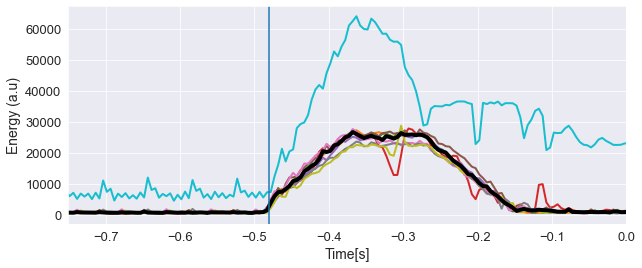

In [8]:
ts = np.linspace(win[0], win[1], emptyArray.shape[0])

plt.figure(figsize=(10,4))
for index, row in arm_instructions.iterrows():
        if row["HasData"]:
                plt.plot(ts, row["AlignedMovieEnergy"], lw = 2)

avg = np.nanmedian(np.vstack([row['AlignedMovieEnergy'] for index, row  in arm_instructions.iterrows()]), axis=0)
plt.plot(ts, avg, c = "black", lw = 4)
plt.xlabel("Time[s]")
plt.ylabel("Energy (a.u)")
plt.xlim((-.75, 0))
plt.axvline(-0.48)
plt.show()

